# **Product Recognition of Food Products**

## Image Processing and Computer Vision - Assignment Module \#1


Contacts:

- Prof. Giuseppe Lisanti -> giuseppe.lisanti@unibo.it
- Prof. Samuele Salti -> samuele.salti@unibo.it
- Alex Costanzino -> alex.costanzino@unibo.it
- Francesco Ballerini -> francesco.ballerini4@unibo.it


Computer vision-based object detection techniques can be applied in super market settings to build a system that can identify products on store shelves.
An example of how this system could be used would be to assist visually impaired customers or automate common store management tasks like detecting low-stock or misplaced products, given an image of a shelf in a store.

## Task
Develop a computer vision system that, given a reference image for each product, is able to identify such product from one picture of a store shelf.

<figure>
<a href="https://imgbb.com/">
  <center>
  <img src="https://i.ibb.co/TwkMWnH/Screenshot-2024-04-04-at-14-54-51.png" alt="Screenshot-2024-04-04-at-14-54-51" border="0" width="300" />
</a>
</figure>

For each type of product displayed in the
shelf the system should report:
1. Number of instances;
1. Dimension of each instance (width and height in pixel of the bounding box that enclose them);
1. Position in the image reference system of each instance (center of the bounding box that enclose them).

#### Example of expected output
```
Product 0 - 2 instance found:
  Instance 1 {position: (256, 328), width: 57px, height: 80px}
  Instance 2 {position: (311, 328), width: 57px, height: 80px}
Product 1 – 1 instance found:
.
.
.
```

### Track A - Single Instance Detection
Develop an object detection system to identify single instance of products given one reference image for each item and a scene image.

The system should be able to correctly identify all the product in the shelves
image.

### Track B - Multiple Instances Detection
In addition to what achieved at step A, the system should also be able to detect multiple instances of the same product.

## Data
Two folders of images are provided:
* **Models**: contains one reference image for each product that the system should be able to identify.
* **Scenes**: contains different shelve pictures to test the developed algorithm in different scenarios. The images contained in this folder are corrupted by noise.

#### Track A - Single Instance Detection
* **Models**: {ref1.png to ref14.png}.
* **Scenes**: {scene1.png to scene5.png}.

#### Track B - Multiple Instances Detection
* **Models**: {ref15.png to ref27.png}.
* **Scenes**: {scene6.png to scene12.png}.

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

# !cp -r /content/drive/MyDrive/AssignmentsIPCV/dataset.zip ./
# !unzip dataset.zip

## Evaluation criteria
1. **Procedural correctness**. There are several ways to solve the assignment. Design your own sound approach and justify every decision you make;

2. **Clarity and conciseness**. Present your work in a readable way: format your code and comment every important step;

3. **Correctness of results**. Try to solve as many instances as possible. You should be able to solve all the instances of the assignment, however, a thoroughly justified and sound procedure with a lower number of solved instances will be valued **more** than a poorly designed approach.

# START OF OUR CODE

### Imports

In [3]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import os
import math

### Begin by denoising the provided scenes to help the product identifying algorithm

In [ ]:
def DeNoise(dir, newdir, num, img_name):
    '''
    A preprocessing function to repair the noisy scenes!

    Arguments:
    - dir: str, the original directory containing the noisy images.
    - newdir: str, the directory where denoised images will be saved.
    - num: int, the number of images to process.
    '''
    # Create the new directory
    if not os.path.exists(newdir):
        os.mkdir(newdir)

    # Iterate through the image names
    img_names = [f"{img_name}{i}.png" for i in range(1,num+1)]
    for img_name in img_names:
        # Read the image
        img = cv2.imread(dir+img_name)
        # Convert image to RGB
        rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # Remove impulse noise using a median filter
        removed_impulse_img = cv2.medianBlur(rgb_img, 5)
        # Remove Gaussian noise without smoothing using a bilater filter
        filtered_img = cv2.bilateralFilter(removed_impulse_img, d=100, sigmaColor=75, sigmaSpace=75)
        # Convert image to BGR to write it
        filtered_img_bgr = cv2.cvtColor(filtered_img, cv2.COLOR_RGB2BGR) 
        cv2.imwrite(newdir+img_name, filtered_img_bgr)

        # Plotting
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))

        # Plot the original noisy image
        axes[0].imshow(rgb_img)
        axes[0].set_title('Original Image')
        axes[0].axis('off')

        # Plot the filtered denoised image
        axes[1].imshow(filtered_img)
        axes[1].set_title('Denoised Image')
        axes[1].axis('off')

        plt.show()

DeNoise(dir='dataset/scenes/', newdir='dataset/denoised_scenes/', num=12, img_name='scene')

## Task A solution

The solution we found follows these steps:
1. Scenes filtering in order to remove the noise. The used filters are:
    - Median filter for impulse noise.
    - Bilateral filter for Gaussian noise without blurring.
2. Apply for each model on each scene the SIFT algorithm to find the object in the scene.
3. Transform the perspective of the scene image extracting the ROI with the same shape of the model.
4. Apply template matching algorithm in order to filter out wrong SIFT detections.

    

### Add here filtering on scenes part 


### Detection with SIFT
In order to detect object using SIFT feature matching algorithm, the following steps have been implemented:
1. keypoints and descriptors computation of each model and scene;
2. with the help of FLANN implementation of KNN Matching algorithm, the computation of the descriptors matches;
3. filtering out ambiguous matches;
4. filtering out valid detections using a threshold of the minimum number of not ambiguous descriptors matches;
5. bounding box drawing to plot the scene.

#### *keypoints_descriptors_SIFT()*
The function *keypoints_descriptors_SIFT*, given a list of images, returns the lists of keypoints and descriptors computed with SIFT and sorted in the same index position of the input list. 

In [11]:
def keypoints_descriptors_SIFT(imgs):
    sift = cv2.SIFT_create()
    
    imgs_kp = []
    imgs_des = []
    
    if len(imgs) > 0:
        imgs_kp = [sift.detectAndCompute(img, None)[0] for img in imgs]
        imgs_des = [sift.detectAndCompute(img, None)[1] for img in imgs]
    
    return imgs_kp, imgs_des

#### *flann_knn_standard()*
The function *flann_knn_standard*, given the list of models: *model_des* and of scenes: *scene_des*, it returns the found matches using the FLANN implementation of the KNN Match alghoritm. The first 2 closest descriptors are found for each model keypoint. 

In [12]:
def flann_knn_standard(model_des, scene_des):
    FLANN_INDEX_KDTREE = 1

    # Defining parameters for algorithm
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    
    # Defining search params.
    # checks=50 specifies the number of times the trees in the index should be recursively traversed.
    # Higher values gives better precision, but also takes more time
    search_params = dict(checks = 50)
    
    # Initializing matcher
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    
    # Matching and finding the 2 closest elements for each query descriptor.
    matches = flann.knnMatch(model_des,scene_des,k=2)
    return matches

#### *ambiguous_matches_filter()*
The function *ambiguous_matches_filter*, given the list of tuple *matches* and *threshold* (default value 0.7), it returns only the not ambiguous matches. 

In [13]:

def ambiguous_matches_filter(matches, threshold = 0.7):
    '''
    Filters out ambiguous matches.

    Arguments:
    - matches: list[(list[np.array],list[np.array])]: list of matched descriptors.
    - threshold: int, the threshold used for filtering. 
    '''
    good_matches = []
    for m, n in matches:
        if m.distance < threshold*n.distance:
            good_matches.append(m)
    return good_matches

#### *is_detected()*
The function *is_detected*, given the number of keypoints of the model: *num_kp*, the number of matches found *num_matches* and a threshold value: *threshold* determine whether the not ambiguous matches are enough to consider the object detected or not. The threshold must be specified as a decimal percentage and represents the minimum number of keypoints in the model required to consider an object as detected. It returns *True* if the matches are enough, otherwise returns *False*.  
  
The decision of considering the percentage of the model keypoints number as the minimum number of matches is due to the different number of keypoints in each model. Doing so the *MIN_MATCH_COUNT* constant will be related to every single model.

In [14]:
def is_detected(num_kp, num_matches, threshold):
    MIN_MATCH_COUNT = math.ceil(num_kp*threshold)
    return num_matches > MIN_MATCH_COUNT

#### *get_homography()*
The function *get_homography*, given the model keypoints *model_kp*, *scene_kp* and the valid matches list *matches*, compute e returns the homography matrix *M*: 

In [15]:
def get_homography(model_kp, scene_kp, matches):
    src_pts = np.float32([ model_kp[m.queryIdx].pt for m in matches ]).reshape(-1,1,2)
    dst_pts = np.float32([ scene_kp[m.trainIdx].pt for m in matches ]).reshape(-1,1,2)
    
    M, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,10.0)  
    return M

#### *draw_bounding_box()*
The function *draw_bounding_box*, given the model image *model*, the scene image *scene* and the homography matrix *M*, returns the scene with the bounding box highlighting the detected object. It also computes the centroid position of the bounding box, it draws and returns it. The same with the max height and width of the bounding box.   

In [16]:
def centroid_of_polygon(corners):
    num_points = len(corners)
    x_sum = 0
    y_sum = 0

    for x, y in corners:
        x_sum += x
        y_sum += y

    centroid_x = x_sum / num_points
    centroid_y = y_sum / num_points

    return (centroid_x, centroid_y)

In [17]:
def draw_bounding_box(model, scene, M):
    
    # Handle both: grey scale and colored images
    if len(model.shape) == 3:
        h,w, _ = model.shape
    else: 
        h,w = model.shape
        
    model_corners = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    trans_corners = cv2.perspectiveTransform(model_corners,M)
    
    scene_with_bounding_box = cv2.polylines(scene.copy(),[np.int32(trans_corners)],True,(0, 255, 0),10, cv2.LINE_AA)
    
    # Height and Width of boundinx_box
    min_x = np.min(trans_corners[:, :, 0])
    max_x = np.max(trans_corners[:, :, 0])
    min_y = np.min(trans_corners[:, :, 1])
    max_y = np.max(trans_corners[:, :, 1])
    height = max_y - min_y
    width = max_x - min_x
    
    # Centroid
    centroid_position = centroid_of_polygon(trans_corners.reshape(-1, 2))
    cv2.circle(scene_with_bounding_box, tuple(map(int, centroid_position)), radius=5, color=(0,255,0), thickness=10)
    
    return scene_with_bounding_box, centroid_position, height, width

#### *get_ROI_perspective_warped()*
The function *get_ROI_perspective_warped*, given the model image *model*, the scene image *scene* and the homography matrix *M*, it returns the ROI from the scene with the perspective warped. 

In [18]:
def get_ROI_perspective_warped(model, scene, M):
    print(model.shape)
    roi = cv2.warpPerspective(scene, np.linalg.inv(M), (model.shape[1], model.shape[0]))
    return roi

#### *object_detection_SIFT()*
The function *object_detection_SIFT*, given the model image *model*, the scene image *scene* and threshold *threshold*, plot the scene with the bounding box highlighted and returns the image if the object is found in the scene, otherwise in returns *None*. 

In [10]:
def object_detection_SIFT(model, scene, threshold):
    
    sift = cv2.SIFT_create()
    model_kp, model_des = sift.detectAndCompute(model, None)
    scene_kp, scene_des = sift.detectAndCompute(scene, None)
    matches = flann_knn_standard(model_des, scene_des)
    filtered_matches = ambiguous_matches_filter(matches)
    
    # If less than 4 matches, not possible to compute mapping 
    if len(filtered_matches) > 4 and is_detected(len(model_kp), len(filtered_matches), threshold):
        M = get_homography(model_kp, scene_kp, filtered_matches)
        boundingbox_scene, centroid_position, height, width = draw_bounding_box(model, scene, M)
        
        roi = get_ROI_perspective_warped(model, scene, M)
        plt.imshow(roi)
        plt.title('ROI with perspective warped from scene')
        plt.show()
        
        plt.imshow(boundingbox_scene)
        plt.title('Detected object in the scene')
        plt.show()
        
        print('##################################################################################')
        print('Position of the detected object in the scene: ', centroid_position)
        print('Height of bounding box: ', height)
        print('Width of bounding box: ', width)
        print('##################################################################################')
        return boundingbox_scene
    else:
        print('The model hasn\'t been detected in the scene')
        return None

#### Example of right detection with object_detection_SIFT() 

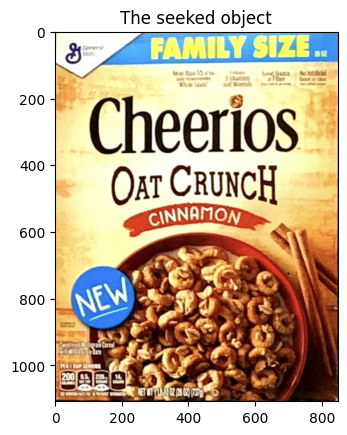

(1108, 848, 3)


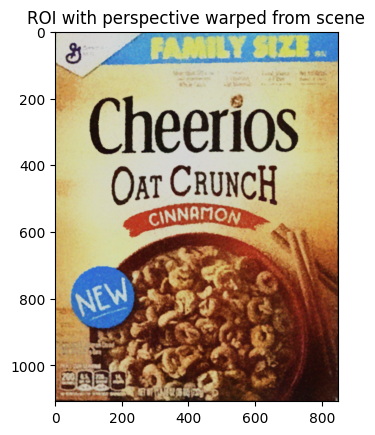

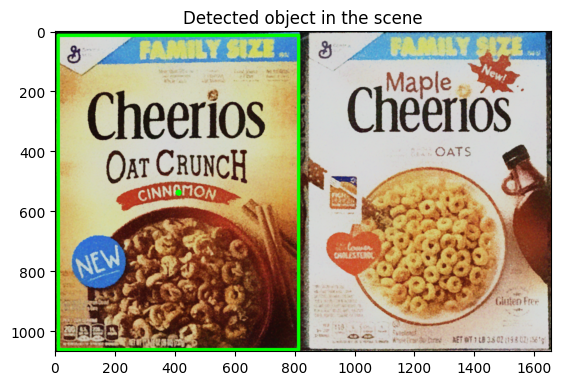

##################################################################################
Position of the detected object in the scene:  (412.0489387512207, 539.0578713417053)
Height of bounding box:  1048.6554
Width of bounding box:  802.3066
##################################################################################


In [11]:
model = cv2.imread('dataset/models/ref1.png') #10
scene = cv2.imread('dataset/denoised_scenes/scene1.png') #4

model = cv2.cvtColor(model, cv2.COLOR_BGR2RGB)
scene = cv2.cvtColor(scene, cv2.COLOR_BGR2RGB)

plt.imshow(model)
plt.title('The seeked object')
plt.show()

_ = object_detection_SIFT(model, scene, 0.01)

#### Example of wrong detection with object_detection_SIFT()

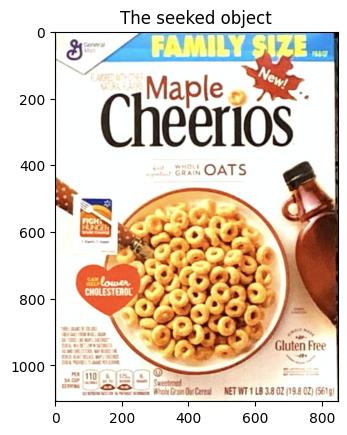

(1108, 848, 3)


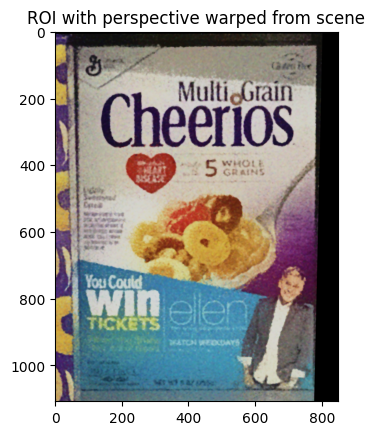

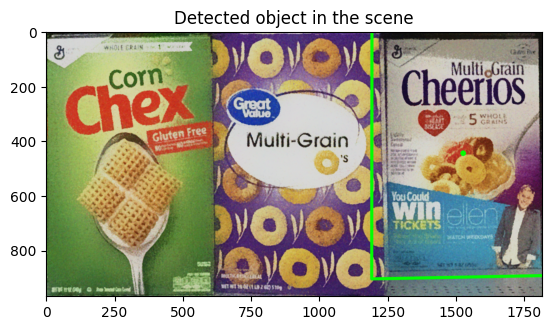

##################################################################################
Position of the detected object in the scene:  (1527.0208129882812, 446.3523083925247)
Height of bounding box:  912.929
Width of bounding box:  678.76184
##################################################################################


In [12]:
model = cv2.imread('dataset/models/ref2.png')
scene = cv2.imread('dataset/denoised_scenes/scene2.png')

model = cv2.cvtColor(model, cv2.COLOR_BGR2RGB)
scene = cv2.cvtColor(scene, cv2.COLOR_BGR2RGB)

plt.imshow(model)
plt.title('The seeked object')
plt.show()

_ = object_detection_SIFT(model, scene, 0.01)

To avoid this wrong detection would be sufficient to increase the threshold (that was 0.01). On the other hand, increasing the threshold would make SIFT missing some detections. To avoid this, we thought to keep low the threshold (keep it 0.01), then doublecheck the SIFT detections using a template matching algorithm. Since template matching is not scaling and rotation invariant, we compare the model with the ROI (with the perspective warped as in the model and same dimension of the model) using the ZNCC similarity function (to handle affine intensity changes). Then we consider only detections with a high coefficient of similarity.

#### SIFT_templatematching_detection()

In [13]:
def SIFT_templatematching_detection(model, scene, sift_th, tmpl_th):
    sift = cv2.SIFT_create()
    model_kp, model_des = sift.detectAndCompute(model, None)
    scene_kp, scene_des = sift.detectAndCompute(scene, None)
    matches = flann_knn_standard(model_des, scene_des)
    filtered_matches = ambiguous_matches_filter(matches)
    
    if len(filtered_matches) > 4 and is_detected(len(model_kp), len(filtered_matches), sift_th):
        M = get_homography(model_kp, scene_kp, filtered_matches)
        boundingbox_scene, centroid_position, height, width = draw_bounding_box(model, scene, M)
        # Checking with templateMatching() the ROI with the model
        roi = get_ROI_perspective_warped(model, scene, M)
        
        matching_coeff = cv2.matchTemplate(model, roi, cv2.TM_CCORR_NORMED)[0][0]
        if matching_coeff > tmpl_th:
            return (boundingbox_scene, centroid_position, height, width)
    return None

#### Iterate SIFT_templatematching_detection() for each model and scene

In [141]:
def RGBimages_listing(dir_path, img_name, num):
    '''
    Function for extraction of RGB images from a specified directory,
    it returns a list of images.
    
    Arguments:
    - dir_path: str, path of the directory.
    - num: int, the first num images to extract.
    - img_name: str, name of the image. 
    '''
    imgs = []
    img_names = [f"{img_name}{i}.png" for i in range(1,num+1)]
    
    for img_name in img_names:
        img = cv2.imread(dir_path+img_name)
        rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        imgs.append(rgb_img)
    return imgs

def plot_result(model, boundingboxes, centroids, heights, widths, model_num, scenes_num):
    print(f'###################################### Detection of model: {model_num+1} ######################################')
    if len(boundingboxes) > 0:
        if len(boundingboxes) == 2:
            rows = 1
            cols = 2
        else:
            rows = math.ceil(math.sqrt(len(boundingboxes)))
            cols = math.ceil(len(boundingboxes) / rows)
            
        fig, axes = plt.subplots(rows+1, cols, figsize=(12, 8))
        fig.suptitle(f'Model {model_num+1}', fontsize=14)
        
        # Check if gray image
        if len(model.shape)==3:
            axes.flat[0].imshow(model)
        else:
            axes.flat[0].imshow(model, cmap='gray')
        axes.flat[0].axis('off')

        for i in range(1, cols):
            axes.flat[i].axis('off')    
            
        for i in range(rows):
            for j in range(cols):
                scene_idx = i * cols + j
                ax_idx = (i+1) * cols + j
                if scene_idx < len(boundingboxes):
                    # Check if gray image
                    if len(model.shape) == 3:
                        axes.flat[ax_idx].imshow(boundingboxes[scene_idx])
                    else:
                        axes.flat[ax_idx].imshow(boundingboxes[scene_idx], cmap='gray')
                    axes.flat[ax_idx].axis('off')
                    print('************************************************************************')
                    print(f'In the scene {scenes_num[scene_idx]+1}:')
                    print('    The position of the detected object in the scene: ', centroids[scene_idx])
                    print('    The height of bounding box is: ', heights[scene_idx])
                    print('    The width of bounding box is: ', widths[scene_idx])
                    print('************************************************************************')
                else:
                    axes.flat[ax_idx].axis('off')
    
    else:
        # Check if gray image
        if len(model.shape)==3:
            plt.imshow(model)
        else:
            plt.imshow(model, cmap='gray')
        plt.title(f'Detection of model {model_num}', fontsize=16)
        print('************************************************************************')
        print('No match was found!')
        print('************************************************************************')
    plt.tight_layout()
    plt.show()
    print()

In [ ]:
scenes_path = 'dataset/denoised_scenes/'
models_path = 'dataset/models/'
scene_name = 'scene'
model_name = 'ref'

models = RGBimages_listing(models_path, model_name, 14)
scenes = RGBimages_listing(scenes_path, scene_name, 12)

taskA_models = models[:14]
taskA_scenes = scenes[:5]

for i, model in enumerate(taskA_models):
    scenes_num = []
    boundingboxes = []
    centroids = []
    heights = []
    widths = []
    for j, scene in enumerate(taskA_scenes):
        result =  SIFT_templatematching_detection(model, scene, 0.01, 0.95)
        if result is not None:
            scenes_num.append(j)
            boundingboxes.append(result[0])
            centroids.append(result[1])
            heights.append(result[2])
            widths.append(result[3])
    plot_result(model, boundingboxes, centroids, heights, widths, i, scenes_num)



## Task B

In [142]:
scenes_path = 'dataset/denoised_scenes/'
models_path = 'dataset/models/'
scene_name = 'scene'
model_name = 'ref'

models = RGBimages_listing(models_path, model_name, 27)
scenes = RGBimages_listing(scenes_path, scene_name, 12)

taskB_models = models[14:]
taskB_scenes = scenes[5:]



In [129]:
def get_homography_B(model_kp, scene_kp, matches):
    src_pts = np.float32([ model_kp[m.queryIdx].pt for m in matches ]).reshape(-1,1,2)
    dst_pts = np.float32([ scene_kp[m.trainIdx].pt for m in matches ]).reshape(-1,1,2)
    
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,10.0)  
    return M, mask

def remove_istance_kp_and_des(scene_kp, scene_des, mask):
    filtered_scene_kp = []
    filtered_scene_des = []
    for i, (kp, des) in enumerate(zip(scene_kp, scene_des)):
        if not mask[i]:
            filtered_scene_kp.append(kp)
            filtered_scene_des.append(des)
    return np.float32(filtered_scene_kp), np.float32(filtered_scene_des)

In [147]:
def draw_bounding_box_B(model, scene, M):
    
    # Handle both: grey scale and colored images
    if len(model.shape) == 3:
        h,w, _ = model.shape
    else: 
        h,w = model.shape
        
    model_corners = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    trans_corners = cv2.perspectiveTransform(model_corners,M)
    
    scene_with_bounding_box = cv2.polylines(scene,[np.int32(trans_corners)],True,(0, 255, 0),10, cv2.LINE_AA)
    
    # Height and Width of boundinx_box
    min_x = np.min(trans_corners[:, :, 0])
    max_x = np.max(trans_corners[:, :, 0])
    min_y = np.min(trans_corners[:, :, 1])
    max_y = np.max(trans_corners[:, :, 1])
    height = max_y - min_y
    width = max_x - min_x
    
    # Centroid
    centroid_position = centroid_of_polygon(trans_corners.reshape(-1, 2))
    cv2.circle(scene_with_bounding_box, tuple(map(int, centroid_position)), radius=5, color=(0,255,0), thickness=10)
    
    return scene_with_bounding_box, centroid_position, height, width, trans_corners

In [148]:
def point_in_parallelogram(point, parallelogram):
    """
    Check if a point is within a parallelogram.

    Parameters:
        point: tuple, representing the (x, y) coordinates of the point.
        parallelogram: list of tuples, representing the (x, y) coordinates of the vertices of the parallelogram.

    Returns:
        bool: True if the point is within the parallelogram, False otherwise.
    """
    def sign(p1, p2, p3):
        return (p1[0] - p3[0]) * (p2[1] - p3[1]) - (p2[0] - p3[0]) * (p1[1] - p3[1])

    b1 = sign(point, parallelogram[0][0], parallelogram[1][0]) < 0.0
    b2 = sign(point, parallelogram[1][0], parallelogram[2][0]) < 0.0
    b3 = sign(point, parallelogram[2][0], parallelogram[3][0]) < 0.0
    b4 = sign(point, parallelogram[3][0], parallelogram[0][0]) < 0.0

    return ((b1 == b2) and (b2 == b3) and (b3 == b4))

def point_inside_polygon(x, y, polygon):
    """
    Check if a point (x, y) is inside a polygon.

    Parameters:
        x: float, x-coordinate of the point.
        y: float, y-coordinate of the point.
        polygon: list of tuples, representing the vertices of the polygon.

    Returns:
        bool: True if the point is inside the polygon, False otherwise.
    """
    n = len(polygon)
    inside = False
    p1x, p1y = polygon[0]
    for i in range(n + 1):
        p2x, p2y = polygon[i % n]
        if y > min(p1y, p2y):
            if y <= max(p1y, p2y):
                if x <= max(p1x, p2x):
                    if p1y != p2y:
                        xinters = (y - p1y) * (p2x - p1x) / (p2y - p1y) + p1x
                    if p1x == p2x or x <= xinters:
                        inside = not inside
        p1x, p1y = p2x, p2y
    return inside


def removeBoundedKP(scene_des, scene_kp, corners):
    coords = [kp.pt for kp in scene_kp]
    filtered_scene_des = []
    filtered_scene_kp = []
    
    kp_to_be_deleted = []
    for idx, coord in enumerate(coords):
        if not point_in_parallelogram(coord, corners):
            filtered_scene_des.append(scene_des[idx])
            filtered_scene_kp.append(scene_kp[idx])
        else:
            kp_to_be_deleted.append(coord)
    clipped = len(scene_kp) - len(filtered_scene_kp)
    print(f"We have removed {clipped} descriptors out of {len(scene_kp)}!")
    
    return np.array(filtered_scene_des), np.array(filtered_scene_kp), kp_to_be_deleted


In [153]:
def object_detection_SIFT_B(model, scene, threshold):
    
    sift = cv2.SIFT_create()
    model_kp, model_des = sift.detectAndCompute(model, None)
    scene_kp, scene_des = sift.detectAndCompute(scene, None)
    
    more_istances = True
    num_ist = 0
    
    boundingboxscene = scene
    filtered_scene_kp = scene_kp
    filtered_scene_des = scene_des
    kp_to_be_deleted = []
    
    while more_istances:
        matches = flann_knn_standard(model_des, filtered_scene_des)    
        filtered_matches = ambiguous_matches_filter(matches)
        
        # If less than 4 matches, not possible to compute mapping 
        print('Numero di model_kp:', len(model_kp))
        if len(filtered_matches) > 4 and is_detected(len(model_kp), len(filtered_matches), threshold) and (num_ist == 0 or len(kp_to_be_deleted) != 0):
            num_ist += 1
            
            #There could be a problem
            M, _ = get_homography_B(model_kp, scene_kp, filtered_matches)
            
            boundingboxscene, centroid, height, width, corners = draw_bounding_box_B(model, boundingboxscene, M)
            
            filtered_scene_des, filtered_scene_kp, kp_to_be_deleted = removeBoundedKP(filtered_scene_des, filtered_scene_kp, corners)
            
            scene_copy = scene.copy()
            for point in kp_to_be_deleted:
                cv2.circle(scene_copy, (int(point[0]), int(point[1])), 5, (0, 255, 0), 20)
                
            plt.imshow(scene_copy)
            plt.show()
            
            print(f"Number of filtered matches: {len(filtered_matches)}")
            print(f"Number of filtered scene descriptors: {len(filtered_scene_des)}")
        else:
            more_istances = False
    
    return boundingboxscene

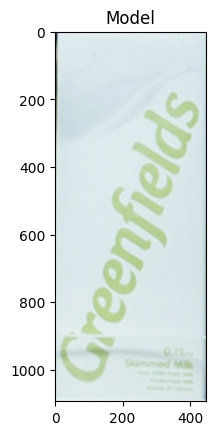

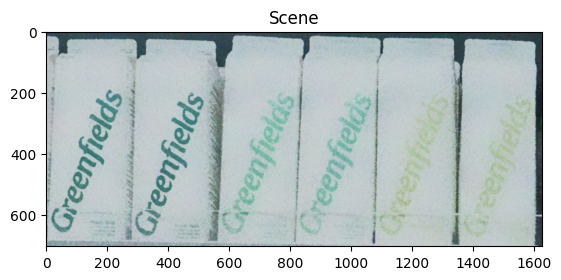

Numero di model_kp: 83
We have removed 319 descriptors out of 2024!


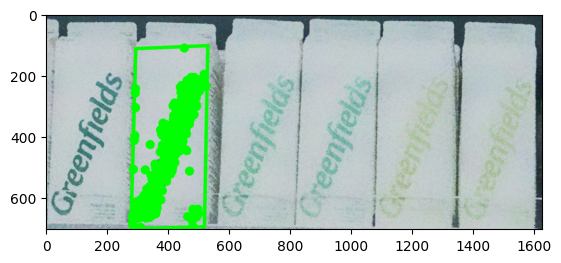

Number of filtered matches: 34
Number of filtered scene descriptors: 1705
Numero di model_kp: 83
We have removed 372 descriptors out of 1705!


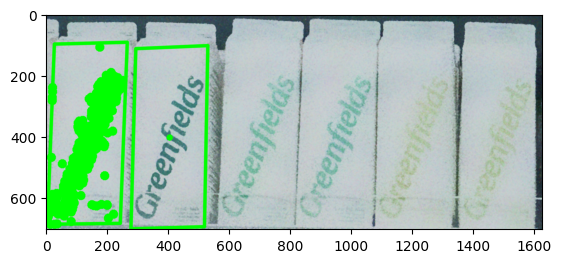

Number of filtered matches: 37
Number of filtered scene descriptors: 1333
Numero di model_kp: 83
We have removed 0 descriptors out of 1333!


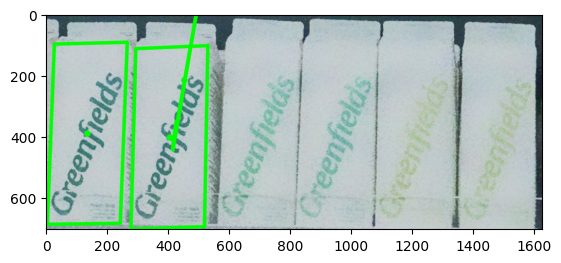

Number of filtered matches: 14
Number of filtered scene descriptors: 1333
Numero di model_kp: 83


In [ ]:
model = cv2.imread('dataset/models/ref18.png')
model2 = cv2.imread('dataset/models/ref26.png')
scene = cv2.imread('dataset/denoised_scenes/scene12.png')

model = cv2.cvtColor(model, cv2.COLOR_BGR2RGB)
scene = cv2.cvtColor(scene, cv2.COLOR_BGR2RGB)

plt.imshow(model)
plt.title('Model')
plt.show()

plt.imshow(scene)
plt.title('Scene')
plt.show()

bounding = object_detection_SIFT_B(model, scene, 0.05)
plt.imshow(bounding)
plt.show()
#right_roi = object_detection_SIFT_B(model2, scene, 0.01)

#result = cv2.matchTemplate(model, wrong_roi, cv2.TM_SQDIFF)[0][0]
#result2 = cv2.matchTemplate(model2, right_roi, cv2.TM_SQDIFF)[0][0]
#print('Wrong match result: ', result)
#print('Right match result: ', result2)

# THIS CODE BELOW TO BE DELETED BEFORE SUBMISSION

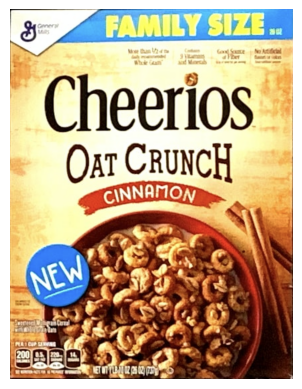

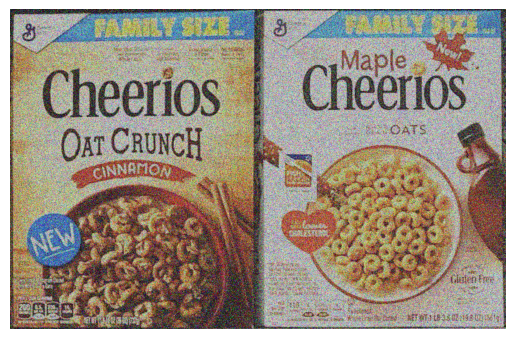

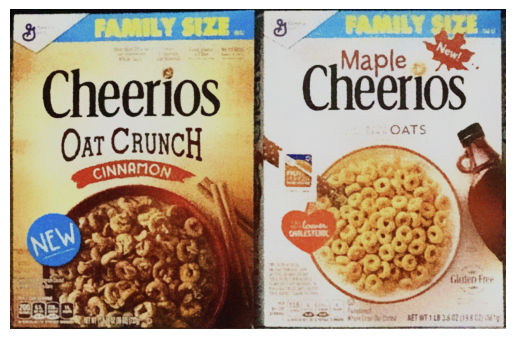

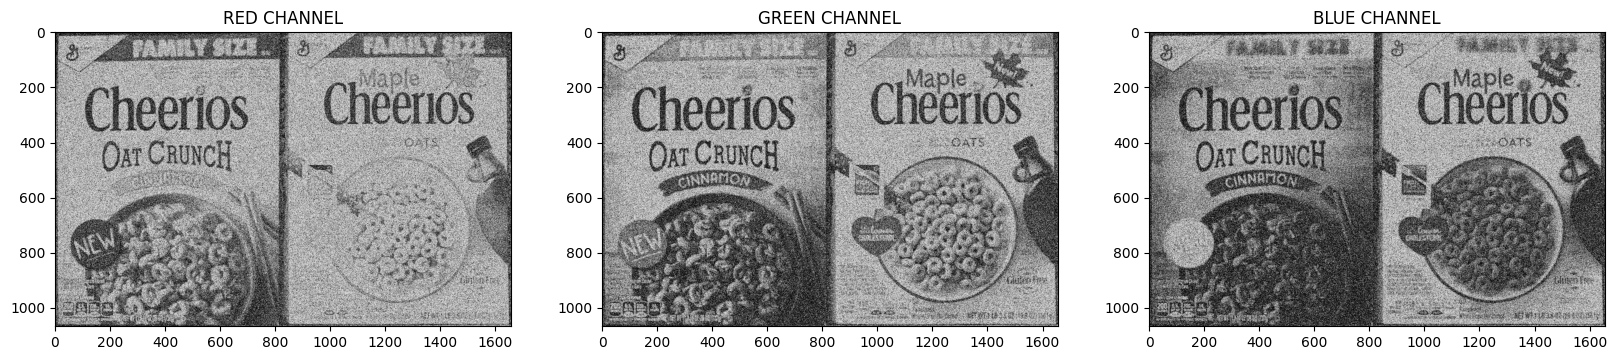

In [ ]:
# Could be usefull
def find_origin_offset(homography_matrix):
    # Find the inverse of the homography matrix
    inverse_homography_matrix = np.linalg.inv(homography_matrix)

    # Define the origin point (0,0)
    origin_point = np.array([[0, 0]], dtype=np.float32)

    # Apply perspective transformation to the origin point using the inverse homography matrix
    mapped_origin = cv2.perspectiveTransform(origin_point.reshape(-1, 1, 2), inverse_homography_matrix)

    # Extract the x and y coordinates of the mapped origin
    x_offset = mapped_origin[0, 0, 0]
    y_offset = mapped_origin[0, 0, 1]

    return x_offset, y_offset

def apply_offset_to_homography(homography_matrix):
    x_offset, y_offset = find_origin_offset(homography_matrix)
    # Define the translational homography matrix
    offset_matrix = np.array([[1, 0, x_offset],
                              [0, 1, y_offset],
                              [0, 0, 1]])

    # Perform matrix multiplication to apply the offset
    new_homography_matrix = np.dot(offset_matrix, homography_matrix)

    return new_homography_matrix

def zncc(image1, image2):
    # Convert images to float32
    image1 = image1.astype(np.float32)
    image2 = image2.astype(np.float32)
    
    # Compute mean of each image
    mean1 = np.mean(image1)
    mean2 = np.mean(image2)
    
    # Compute zero-mean images
    zero_mean_image1 = image1 - mean1
    zero_mean_image2 = image2 - mean2
    
    # Compute cross-correlation
    cross_corr = np.sum(zero_mean_image1 * zero_mean_image2)
    
    # Compute standard deviations
    std1 = np.sqrt(np.sum(zero_mean_image1 ** 2))
    std2 = np.sqrt(np.sum(zero_mean_image2 ** 2))
    
    # Compute ZNCC
    zncc_value = cross_corr / (std1 * std2)
    
    return zncc_value

def blurratore(img, kernel_size, sigma):
    img_blurred = img
    for i in range(100):
        img_blurred = cv2.GaussianBlur(img_blurred, kernel_size, sigma)
    return img_blurred

def RGBimages_listing_from_to(dir_path, img_name, fr, to):
    '''
    Usefull function for testing. Must be deletet before submission.
    '''
    imgs = []
    img_names = [f"{img_name}{i}.png" for i in range(fr,to+1)]
    
    for img_name in img_names:
        img = cv2.imread(dir_path+img_name)
        rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        imgs.append(rgb_img)
    return imgs
# Load a reference image
img = cv2.imread("dataset/models/ref1.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Load a scene
scene = cv2.imread("dataset/scenes/scene1.png")
scene = cv2.cvtColor(scene, cv2.COLOR_BGR2RGB)

# Print
plt.imshow(img)
plt.axis('off')
plt.show()
plt.imshow(scene)
plt.axis('off')
plt.show()

filter_scene = scene.copy()

# Use a median filter to remove impulse noise
# Define the size of the impulse kernel (e.g., 3x3)
kernel_size = 10

# # Create an impulse kernel
# impulse_kernel = np.zeros((kernel_size, kernel_size), dtype=np.uint8)
# center = (kernel_size - 1) // 2
# impulse_kernel[center, center] = 1
# filter_scene = cv2.filter2D(filter_scene, -1, impulse_kernel)

# Create a median filter
filter_scene = cv2.medianBlur(filter_scene, 5)

# Follow by linear filtering to remove guassian noise

# A simple mean filter
k_size = 9
mean_kernel = np.ones([k_size, k_size])/(k_size**2)
# filter_scene = cv2.filter2D(filter_scene, -1, mean_kernel)

# An API Guassian filter
# filter_scene = cv2.GaussianBlur(filter_scene, (9, 9), 5)

# Bilaterial filter
filter_scene = cv2.bilateralFilter(filter_scene, d=100, sigmaColor=75, sigmaSpace=75)

# IDEA: THERE IS MORE NOISE IN SOME R, G, B CHANNELS THAN OTHERS?

plt.imshow(filter_scene)
plt.axis('off')
plt.show()

# Print the seperate R,G,B channels
R = scene[:,:,0] # Getting the first axis (R)
G = scene[:,:,1] # Getting the second axis (G)
B = scene[:,:,2] # Getting the third axis (B)

plt.figure(figsize = (20, 10))

plt.subplot(1,3,1)
plt.imshow(R, cmap = 'gray', vmin = 0, vmax = 255)
plt.title('RED CHANNEL')

plt.subplot(1,3,2)
plt.imshow(G, cmap = 'gray', vmin = 0, vmax = 255)
plt.title("GREEN CHANNEL")

plt.subplot(1,3,3)
plt.imshow(B, cmap = 'gray', vmin = 0, vmax = 255)
plt.title("BLUE CHANNEL")

plt.show()